# Practical Part of Assignment 1 - IFT6135-H19

**Team member**: Qiang Ye (20139927)

## Support for Computation on Google Colab

In [1]:
from os.path import exists
from google.colab import drive
import os
drive.mount('/content/dirve/', force_remount = True)


Mounted at /content/dirve/


In [0]:
os.chdir("dirve/My Drive/Colab Notebooks/IFT6135/hw1/")
#!ls -al

## Problem 1

### Building the Model

#### 1. Possible hidden dims settings for number of parameters fallen into [0.5M, 1M]

Consider a MLP with 2 hidden layers with $h^{(1)}$ and $h^{(2)}$ hidden units, an input layer with feature number of $h^{(0)} = 784$ and an output layer with number of labels $h^{(3)} = 10$,  the total number of parameters($\#P\_total$) is:

\begin{align*}
\#P\_total &= \#P\_hidden1 + \#P\_hidden2 + \#P\_output\\
&= h^{(1)}  (h^{(0)} + 1) + h^{(2)}(h^{(1)} + 1) + h^{(3)}(h^{(2)}+1)\\
\end{align*}

In [0]:
def num_parameters(h1, h2, h0 = 784, h3 = 10):
    p_hidden1 = h1 * (h0 + 1)
    p_hidden2 = h2 * (h1 + 1)
    p_output = h3 * (h2 + 1)
    p_total = p_hidden1 + p_hidden2 + p_output
    return p_total

In [4]:
dim_options = [128, 256, 512, 1024, 2048, 4096]
print("Possible values of (h1, h2):")

for h1 in dim_options:
    for h2 in dim_options:
        if 5e5 <= num_parameters(h1, h2) <= 1e6:
            print("({}, {})".format(h1, h2))

Possible values of (h1, h2):
(128, 4096)
(256, 2048)
(512, 256)
(512, 512)
(512, 1024)
(1024, 128)


#### 2. Implementation of a MLP class

In [0]:
%matplotlib inline
from utils import print_progress
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
import time

In [0]:
class NN(object):
    def __init__(self, 
                 #hidden_dims = (512, 256), 
                 #n_hidden = None, 
                 learning_rate = 1e-4,
                 max_epochs = 10,
                 batch_size = 1, # stochastic gradient descent
                 input_dim = 784,
                 output_dim = 10,
                 activate_func = "ReLU",
                 early_stop = False,
                 mode = 'train', 
                 #weight_init_mode = 'Glorot',
                 data_path = None, 
                 model_path = None,
                 verbose = False,
                 #random_seed = 0
                ):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = None # hidden_dims
        self.dims = None # self._generate_dims()
        self.n_hidden = None
        #if type(hidden_dims) in [list, tuple]:
        #    self.n_hidden = len(hidden_dims)
        #else:
        #    self.n_hidden = n_hidden # number of hidden layers
        
        # Ws[0],bs[0] always be None
        # Ws[1] connects inputlayer to 1st hidden layer
        # bs[1] is the bias of 1st hidden layer
        self.Ws = None #[None] * (self.n_hidden + 2) 
        self.bs = None #[None] * (self.n_hidden + 2) 

        self.activate_func = activate_func # nonlinear activate function
        self.lr = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.early_stop = early_stop
        self.verbose = verbose
        self.mode = mode
        self.data_path = data_path
        self.model_path = model_path
        self.random_seed = None # random_seed
        
        self.weight_init_mode = None # weight_init_mode
        return
    
    
    def _generate_dims(self):
        """generate the nn layer dims, including the input and output layer
        """
        dims = [self.input_dim]
        dims.extend(list(self.hidden_dims))
        dims.extend([self.output_dim])
        return dims
    
        
    def load_data(self, dataset_type = "train"):
        """load specified dataset from data_path
        Params
            dataset_type: specify the type of the dataset, str. Example: "train"
            ,"valid", "test"
        Returns
            dataset, tuple (X, y) where shape of X is (sample_size, n_feature), 
            shape of y is (sample_size, )
        """
        with gzip.open(self.data_path,'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            data_set = u.load()
            # all _data are tuple with 2 elements: X, and y with shape like
            # (50000, 784) and (50000, ) respectively
        dataset_type = dataset_type.upper()
        if dataset_type == "TRAIN":
            return data_set[0]
        elif dataset_type == "VALID":
            return data_set[1]
        else: # test
            return data_set[2]
    
        
    def initialize_weights(self, hidden_dims, n_hidden = None,
                           init_mode = 'Glorot', random_seed = 0):
        """initialize weights and bias according to the attributes given.
        """
        self.hidden_dims = hidden_dims
        if type(hidden_dims) in [list, tuple]:
            self.n_hidden = len(hidden_dims)
        else:
            self.n_hidden = n_hidden # number of hidden layers
        
        self.dims = self._generate_dims()
        self.random_seed = random_seed
        self.weight_init_mode = init_mode
        
        self.Ws = [None] * (self.n_hidden + 2)
        self.bs = [None] * (self.n_hidden + 2)
        
        np.random.seed(self.random_seed)
        dims = self.dims
        
        for i in range(1, len(dims)): 
            init_mode = init_mode.upper()
            weight_shape = (dims[i], dims[i-1])
            if init_mode == "ZERO":
                self.Ws[i] = np.zeros(weight_shape)
            elif init_mode == "NORMAL":
                self.Ws[i] = np.random.normal(0, 1, weight_shape)
            else: # ‘Glorot'
                high = float(np.sqrt(6.0/(dims[i] + dims[i-1])))
                self.Ws[i] = np.random.uniform(-1 * high, high, weight_shape)

            self.bs[i] = np.zeros((dims[i], 1))
                    
        return
    
    
    def zero_grad(self):
        """prepare zero grad of weight and bias parameters
        Params
            None
        Returns
            grad_Ws, grad_bs
        """
        grad_Ws = [None] * (self.n_hidden + 2) # grad_Ws[0] always None
        grad_bs = [None] * (self.n_hidden + 2) # grad_bs[0] always None
        for i in range(1, self.n_hidden+2):
            grad_Ws[i] = np.zeros_like(self.Ws[i])
            grad_bs[i] = np.zeros_like(self.bs[i])
        return grad_Ws, grad_bs
    
    
    def forward(self, X):
        """forward process of the network
        Params
            X: input (batch_size, input_features)
        Returns
            cache: a dictionary of all intermediate and final output.
        """
        h_x = X # h_x is output of the layer
        cache = {"X": X, "h0": X} # there's no "a0"
        for i in range(1, self.n_hidden + 2):
            # a_x is pre-activate value of a layer
            # h_x is output of a layer
            a_x = np.dot(h_x, self.Ws[i].T) + self.bs[i].T
            if i == self.n_hidden + 1: # output layer
                h_x = self.softmax(a_x)
                cache["ao"] = a_x
                cache["ho"] = h_x
            else: # hidden layer(s)
                h_x = self.activation(a_x, self.activate_func)
                cache["a"+str(i)] = a_x
                cache["h"+str(i)] = h_x
        
        return cache
    
    
    def activation(self, X, func = "RELU"):
        """compute activation of a Tensor
        Params
            X 
        """
        func = func.upper() #self.activate_func.upper()
        if func == "TANH":
            e_pos = np.exp(X)
            e_neg = np.exp(-1 * X)
            return (e_pos - e_neg)/(e_pos + e_neg)
        elif func == "SIGMOID":
            return 1.0/(1 + np.exp(-1 * X))
        else:# func in ['ReLU', 'relu', 'RELU', 'Relu']:
            return np.maximum(X, 0)
        
        
    def _derivative(self, h, func = "RELU"):
        """ derivative of certain output of activation functions using 
        output of activation function
        """
        func = func.upper() #self.activate_func.upper()
        if func == 'TANH':
            return 1 - np.power(h, 2)
        elif func == 'SIGMOID':
            return np.multiply(h, 1-h)
        else:# func in ['ReLU', 'relu', 'RELU', 'Relu']:
            return np.sign(h)
        
    
    def loss(self, ho, labels):
        """compute average loss
        params
            ho: output of network (batch_size, output_dim)
            labels: true label (batch_size, class_index)
        returns
            loss, average loss on batch_size samples, float
        """
        #print(prediction)
        batch_size, output_dim = ho.shape
        #labels = labels.reshape(-1, 1)
        labels = labels.astype(int)

        ho_labels_probs = ho[np.arange(batch_size), labels]
        # to avoid log(0)
        ho_labels_probs = np.maximum(ho_labels_probs, 1e-100)
        loss = np.mean(-np.log(ho_labels_probs))
        return float(loss)
    
    
    def accuracy(self, ho, labels):
        """compute average accuracy
        params
            ho: output of network (batch_size, output_dim)
            labels: true label (batch_size, class_index)
        returns
            accuracy, average accuracy on batch_size samples, float
        """
        batch_size, output_dim = ho.shape
        labels = labels.reshape(-1, )
        labels = labels.astype(int)
        ho_labels = np.argmax(ho, axis = 1)
        return float(np.sum(ho_labels == labels) / len(ho_labels))

    
    def softmax(self, ao):
        """return softmax of pre-activate value of final layer
        Params
            ao: pre-activate value of final layer, (batch_size, n_class)
        Returns
            probs: (batch_size, n_class)
        """
        if len(ao.shape) == 1: # shape like (4,)
            ao = ao.reshape(1, -1)
        
        ao_max = np.max(ao, axis = 1, keepdims = True)
        sum_exp_ao = np.sum(np.exp(ao - ao_max), axis = 1, keepdims = True)
        return np.exp(ao - ao_max) / sum_exp_ao
    
    
    def _one_hot(self, output_dim, labels):
        labels = labels.reshape(-1, ) # (batch_size, )
        labels = labels.astype(int)
        batch_size = labels.shape[0]
        result = np.zeros((batch_size, output_dim))
        result[np.arange(batch_size), labels] = 1
        return result
    
    
    def backward(self, cache, labels):
        """backward process of a neural network
        Params
            cache: output of function forward, a dictionary of intermediate 
                output neural network
            labels:true label of dataset
        Returns
            (grads_Ws, grads_bs), tuple 
        """
        ao = cache["ao"]
        ho = cache["ho"]
        X = cache["X"]
        grad_Ws, grad_bs = self.zero_grad()
        
        batch_size, output_dim = ho.shape
        # skip calculating grad_ho, we directly calculate grad_ao,
        # as grad_ao is easy to be calculated.
        grad_ao = ho - self._one_hot(output_dim, labels)
        
        i = self.n_hidden + 1 #  i = 3 if n_hidden = 2
        grad_Ws[i] = np.dot(grad_ao.T, cache["h"+str(i-1)])
        grad_bs[i] = grad_ao
        
        grad_a = grad_ao
        for i in range(self.n_hidden, 0, -1):
            # a is pre-activate value of a (hidden) layer
            # h is a output of a layer.
            a = cache["a"+str(i)] # pre-activation
            h = cache["h"+str(i)] # activated output
            
            grad_h = np.dot(grad_a, self.Ws[i+1])
            grad_a = np.multiply(grad_h, self._derivative(h, self.activate_func))
            
            grad_Ws[i] = np.dot(grad_a.T, cache["h"+str(i-1)])
            grad_bs[i] = grad_a
            
       
        for i in range(self.n_hidden+1, 0, -1):
            grad_Ws[i] /= batch_size
            grad_bs[i] = np.mean(grad_bs[i], axis = 0, keepdims = True).T

        grads = (grad_Ws, grad_bs)
        return grads
    
    
    def update(self, grads, learning_rate = 1e-4):
        """pudate parameters
        Params
            learning_rate: learning_rate, float
        Returns
            None
        """
        lr = learning_rate
        for i in range(1, self.n_hidden + 2):
            self.Ws[i] -= lr * grads[0][i]
            self.bs[i] -= lr * grads[1][i]
        
        return
    
            
    def train(self, 
              batch_size = 1,  
              learning_rate = 1e-3, 
              activate_func = "Relu",
              show_live_progress = True,
              epoch_patience = 20,
              max_epochs = 10,
              early_stop = True,
              model_path = 'model_auto_save.pkl',
              auto_save_interval = 10
             ):
        """training a neural network. at each epoch, training the model on 
        training dataset, and then compute loss and accuracy on validate dataset
        Params
            batch_size: mini_batch_size, int
            learning_rate: learning_rate, float
            activate_func: activate function, str
            show_live_progress: if display live training progress, bool
            epoch_patience: patient epoch for early stopping, int
            max_epochs: max epochs for training, int
            early_stop: if early stopping is applicable, bool
        Returns
            (losses, accuracies, best_acc)
            losses: {"train":[], "val":[]} 
            accuracies: {"train":[], "val":[]}
            best_acc: best accuracy on validate set.
        """
        
        self.activate_func = activate_func
        #self.mode = mode
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.lr = learning_rate
        self.early_stop = early_stop
        
        #print("traing hyper-parameters:")
        print("hidden dims:{}".format(self.hidden_dims), end = " ")
        print("lr:{},".format(self.lr), end = " ")
        print("{},".format(self.activate_func), end = " ")
        print("batch size:{},".format(self.batch_size))
        print("max epochs:{},".format(self.max_epochs), end = " ")
        print("early stopping:{},".format(early_stop), end = " ")
        print("patience:{}".format(epoch_patience))
        
        best_acc = {'train':0.0, 'val':0.0} 
        losses = {'train': [], 'val':[]}
        accuracies = {'train': [], 'val':[]}
        patience_used = 0         # patience used
        early_stopped = 0
        start = time.time()
        dataset = {"train": self.load_data("train"),
                  "val": self.load_data("val")}
        
        for epoch in range(self.max_epochs):
            since  = time.time()
            s_before = '[Epoch{:>3d}/{} '.format(epoch, self.max_epochs - 1)
            s_after = ']'
            if show_live_progress:
                print_progress(0, 0, s_before, s_after)
            else:
                # print(s_before + s_after, end = "")
                pass
            
            for mode in ['train', 'val']:
                since_mode = time.time()
                
                loss, acc = 0.0, 0.0
                if show_live_progress:
                    print_progress(0, 0, s_before, s_after)
                
                X, y = dataset[mode]
                # shuffle data during training 
                if mode == "train":
                    data = np.concatenate((X, y.reshape(-1, 1)), axis = 1)
                    np.random.shuffle(data)
                    X, y = data[:,:-1], data[:,-1]
                    y = y.reshape(-1, )
                    
                # X (50000, 784), y (50000, )
                sample_size, _ = X.shape
                batches = int(np.ceil(sample_size / self.batch_size))
                
                for j in range(batches):
                    b_start = j * self.batch_size
                    b_end = min(sample_size, (j+1) * self.batch_size)
                    batch_X = X[b_start:b_end, :]
                    batch_y = y[b_start:b_end]
                    cache = self.forward(batch_X)
                    if mode == "train":
                        grads = self.backward(cache, batch_y)
                        self.update(grads, self.lr)

                    ho = cache["ho"]
                    #factor =  (b_end - b_start) / b_end
                    #loss += (self.loss(ho, batch_y) - loss) * factor
                    #acc += (self.accuracy(ho, batch_y) - acc) * factor

                    loss += self.loss(ho, batch_y) * (b_end - b_start)
                    acc += self.accuracy(ho, batch_y) * (b_end - b_start)
                    if show_live_progress:
                        time_elapsed = time.time() - since_mode
                        print_progress(b_end/sample_size, 
                                       time_elapsed, 
                                       s_before, 
                                       s_after)
                    # end batch loop
                
                loss /= sample_size
                acc /= sample_size
                
                losses[mode].append(loss)
                accuracies[mode].append(acc)
                time_elapsed = time.time() - since_mode
                
                s_after += " {} loss: {:.4f}, accuracy: {:<7.2%}".format(
                    mode, loss, acc)
                
                
                if acc > best_acc[mode]:
                    best_acc[mode] = acc
                    if mode == "val":
                        s_after += " *"
                        patience_used = 0
                else:
                    if mode == "val":
                        patience_used += 1
                        if early_stop and patience_used >= epoch_patience:
                            early_stopped = epoch - epoch_patience

                if show_live_progress:
                    print_progress(1, time_elapsed, s_before, s_after)
                else:
                    #print(' {} loss: {:.4f} acc: {:<7.2%} '.format(
                    #    mode, loss, acc), end = " ")   
                    pass
                # end mode loop
                
            time_elapsed = time.time() - since
            if show_live_progress:
                print_progress(1, time_elapsed, s_before, s_after)
            else:
                #print(' {:.0f}m{:.0f}s'.format(
                #    time_elapsed // 60, time_elapsed % 60), end = "") 
                pass
            print()

            if epoch % auto_save_interval == 0:
                self.save_model(model_path)
            
            if early_stopped > 0:
                print("Early stopped at epoch: {}".format(early_stopped))
                break
            
            if best_acc['val'] >= 0.97:
                print("Accuracy on validate set arrives 0.97, stop training")
                break
                
            # end epoch loop
                
        time_elapsed = time.time() - start
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc on val:   {:.2%}'.format(best_acc['val']))
                
        return (losses, accuracies, best_acc['val'])
    
    
    def test(self):
        # no need so far.
        pass
    
    def save_model(self, filename):
        with open(filename, 'wb') as output:  # Overwrites any existing file.
            pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)
    
    def load_model(self, filename):
        with open(filename, 'rb') as file:
            self = pickle.load(file)
        
    def net_info(self):
        """display basic net configurations, architecture, total parameters,
        etc.
        """
        print("Activation function: {}".format(self.activate_func))
        if self.dims is None:
            return
        print("{} hidden layers".format(self.n_hidden))
        print("Mode of weghts initialization: {}".format(self.weight_init_mode))
        if self.lr is not None:
            print("learning rate: {}".format(self.lr))
        if self.activate_func is not None:
            print("activate function: {}".format(self.activate_func))
        if self.batch_size is not None:
            print("mini_batch_size: {}".format(self.batch_size))
        num_params = 0
        for i in range(len(self.dims)):
            print("Layer{}:{:>5} neurons.".format(i, self.dims[i]), end = " ")
            if i > 0:
                print("Weights:{}, Bias:{}".format(
                    self.Ws[i].shape, self.bs[i].shape))
                num_params += self.dims[i] * (1 + self.dims[i-1])
            else:
                print("")
        print("Total number of params:{}".format(num_params))

### Initialization

#### 1. Model architecture and training the model using 3 different weights initialization methods.

In [12]:
max_epochs = 10
mlp = NN(data_path = 'mnist.pkl.gz', batch_size = 32,
         activate_func = "ReLU", max_epochs = max_epochs)
mlp.initialize_weights(hidden_dims = (512, 256), init_mode = "Zero")
mlp.net_info()

Activation function: ReLU
2 hidden layers
Mode of weghts initialization: Zero
learning rate: 0.0001
activate function: ReLU
mini_batch_size: 32
Layer0:  784 neurons. 
Layer1:  512 neurons. Weights:(512, 784), Bias:(512, 1)
Layer2:  256 neurons. Weights:(256, 512), Bias:(256, 1)
Layer3:   10 neurons. Weights:(10, 256), Bias:(10, 1)
Total number of params:535818


In [13]:
init_modes = ["Zero", "Normal", "Glorot"]
mode_losses = []
for init_mode in init_modes:
    print("weight init mode: {}".format(init_mode))
    mlp.initialize_weights(hidden_dims = (512, 256), init_mode = init_mode)
    losses, accuracies, best_acc = mlp.train(batch_size = 128, 
                                             learning_rate = 1e-2,
                                             max_epochs = 10)
    mode_losses.append(losses)
    print("")

weight init mode: Zero
hidden dims:(512, 256) lr:0.01, Relu, batch size:128,
max epochs:10, early stopping:True, patience:20
[Epoch  0/9 100.00% 0m10s] train loss: 2.3021, accuracy: 11.33%  val loss: 2.3017, accuracy: 11.35%  *
[Epoch  1/9 100.00% 0m11s] train loss: 2.3015, accuracy: 11.36%  val loss: 2.3013, accuracy: 11.35% 
[Epoch  2/9 100.00% 0m10s] train loss: 2.3013, accuracy: 11.36%  val loss: 2.3011, accuracy: 11.35% 
[Epoch  3/9 100.00% 0m10s] train loss: 2.3011, accuracy: 11.36%  val loss: 2.3011, accuracy: 11.35% 
[Epoch  4/9 100.00% 0m10s] train loss: 2.3011, accuracy: 11.36%  val loss: 2.3010, accuracy: 11.35% 
[Epoch  5/9 100.00% 0m10s] train loss: 2.3011, accuracy: 11.36%  val loss: 2.3010, accuracy: 11.35% 
[Epoch  6/9 100.00% 0m10s] train loss: 2.3011, accuracy: 11.36%  val loss: 2.3010, accuracy: 11.35% 
[Epoch  7/9 100.00% 0m11s] train loss: 2.3010, accuracy: 11.36%  val loss: 2.3010, accuracy: 11.35% 
[Epoch  8/9 100.00% 0m11s] train loss: 2.3010, accuracy: 11.36%  

#### 2. Ploting and comments training loss on 10 epochs using three different weight initializaton methods

The curves are shown by executing codes in next cell. During the first 10 epochs with mini batch size = 32: 
- Initialization with  **Zero** weights, training loss does not change, the model can learn nothing from the training dataset;
- Initialization with **Normal** weights, training loss decreases, while losses are almost ten times larger than losses using Zero and Glorot weight initialization methods. This could happen when **Cross Entropy** function is used to calculate loss, the probability output of true label can be much smaller than the average probability, 0.1 in this case. 
- Initialization with **Glorot** weights, training loss decreases, with the initial probability output of true label very close to the average probability (0.1 in this cases)

The **Glorot** weights initialization methods makes the weights more close to zero and uniformely distributed within a small range around,  which makes the output of the network more uniformely at the begining, while still keeping the ability to quickly learn from training dataset. Method **Zero** initializes all weights to zero such that all gradients are zero and the model cannot learn from training dataset. Method **Normal** assigns relatively large parameters that results in a relatively large scale of initial loss and the decreasing of loss during epochs. 

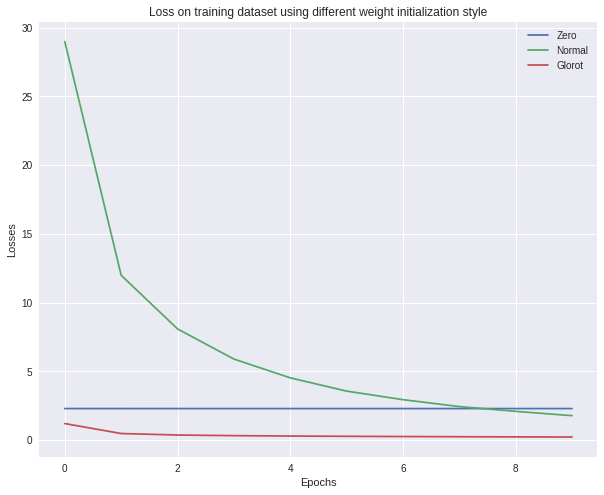

In [14]:
plt.figure(figsize = (10, 8))
epoch_data = np.arange(max_epochs)
for i in range(len(init_modes)):
    plt.plot(epoch_data, mode_losses[i]["train"], label = init_modes[i])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(loc='upper right')
plt.title("Loss on training dataset using different weight initialization style")
plt.show()

### Hyperparameter Search

Below cell helps to search best hyper-parameters settings for our neural model training on MNIST dataset. 
So far, combinations of hyper-parameters we tried all achieved 97% accuracy on validation dataset.  We found that training progress on diferent values of `batch_size`and `learning_rate` differed a lot. Usually, certain batch_size will utilize the efficiency of matrix operation while decrease the speed of the convergence.
 
 Below are the accuracies on validation dataset of different combinations of hyper-parameters we tried. The model will terminate training once the average accuracy on validation dataset achieves 97%.

\begin{array} 
&\text{hidden_dims}  & \text{act_function} & \text{learning_rate}   &      \text{batch_size}     & \text{best train accuracy}     & \text{best_val_accuracy}  & \text{epoch of best val acc}\\
\hline
   (512, 256) & \text{Sigmoid} & 0.1  & 1 &    98.04\% & 97.53\%     &        3 \\
   (512,256) & \text{Relu} & 0.0001  & 1 &    97.82\% & 97.00\%     &  37        \\
   (512,512) & \text{Sigmoid} & 0.1  & 32 &    97.85\% & 97.14\%     & 24         \\
   (512,512) & \text{Sigmoid} & 0.1  & 1 &    98.27\% & 97.56\%     & 4        \\
   (512,512) & \text{Relu} & 0.01  & 32 &    97.78\% &  97.09\%     & 12        \\
      \hline\\
 \end{array}
 


In [0]:
hidden_dimses = [(512, 256), (512, 512)]
learning_rates = [1e-1, 1e-2, 1e-4]
activate_funcs = ["Relu", "Sigmoid"]
mini_batch_sizes = [1, 32, 256]
settings_trained = [(0,0,0,0), (0,0,1,0), (1,0,1,1), (1,1,0,0), (1,1,1,0)]


n_dims = len(hidden_dimses)
n_lrs =  len(learning_rates)
n_funcs = len(activate_funcs)
n_batch_size = len(mini_batch_sizes)

n_search = n_dims * n_lrs * n_funcs * n_batch_size

mlp = NN(data_path = 'mnist.pkl.gz')

for i in range(n_search):
    print("-"* 30)
    dims_index, lr_index, func_index = 0, 0, 0
    while True:
        dims_index = np.random.randint(n_dims)
        lr_index = np.random.randint(n_lrs)
        func_index = np.random.randint(n_funcs)
        batch_size_index = np.random.randint(n_batch_size)
        
        setting = (dims_index, lr_index, func_index, batch_size_index)
        if not setting in settings_trained:
            settings_trained.append(setting)
            break
    
    hidden_dims = hidden_dimses[dims_index]
    learning_rate = learning_rates[lr_index]
    activate_func = activate_funcs[func_index]
    batch_size = mini_batch_sizes[batch_size_index]
        
    mlp.initialize_weights(hidden_dims = hidden_dims, init_mode = "Glorot")
    losses, accuracies, best_acc = mlp.train(batch_size = batch_size, 
                                             learning_rate = learning_rate,
                                             activate_func = activate_func,
                                             max_epochs = 50,
                                             epoch_patience = 5,
                                             show_live_progress = True)


### Validate Gradients using Finite Difference

Two following functions are implemented to perform the gradient check using **one** training sample. Gradient  check of bias is also supported. See comments of the codes for more details of the implementation.  

In [0]:
def grad_finite_diff(mlp, x, label, 
                     layer_index = 1, 
                     param_index = 0,
                     epsilon = 1e-5,
                     use_bias = False):
    """compute gradient of a specified parameter using finite different method.
    on one training sample
    params
        x: a sample (1, 784)
        y: label, int
        layer_index: 1 means the first hidden layer
        param_index: 0 means the first wieght parameter in that layer
        use_bias: whether params_index is of bias matrix
        epsilon: a delta interval of parameter
    returns
        finite different gradient of the parameter, float
    """
    # choose a param (weights or bias tensor of a certain layer
    param = mlp.Ws[layer_index] if not use_bias else mlp.bs[layer_index]
    # access of the index of the param
    h_layer, h_layer_prev = param.shape
    if not use_bias:
        i = param_index // h_layer_prev
        j = param_index % h_layer_prev
    else: # check gradient of a bias
        i = param_index
        j = 0
    # access of old value of a single scalar parameter 
    old_value = param[i, j]    
    # prepare one training sample
    x = x.reshape(1, -1)
    label = np.array([label])
    
    # calculate loss of (old_value + epsilon)
    value_plus = old_value + epsilon
    param[i, j] = value_plus
    cache = mlp.forward(x)
    loss_plus = mlp.loss(cache["ho"], label)
    #print("param_plus:{}, loss_plus: {}".format(value_plus, loss_plus))
    
    # calculate loss of (old_value - epsilon)
    value_minor = old_value - epsilon
    param[i ,j] = value_minor
    cache = mlp.forward(x)
    loss_minor = mlp.loss(cache["ho"], label)
    #print("param_minor:{}, loss_mino: {}".format(value_minor, loss_minor))
    
    # compute gradient by finite difference method.
    grad_finite = (loss_plus - loss_minor)/(2.0 * epsilon)
    param[i, j] = old_value # restore old value.

    #cache = mlp.forward(x)
    #grad_back = mlp.backward(cache, label)[0][layer_index][i, j]
    
    #print(grad_finite, grad_back)
    return grad_finite #, grad_back 


def validate_gradient(mlp, num_params = 10, layer_index = 0, use_bias = False,
                     verbose = True):
    """perform gradient check 
    Params
        mlp: neural network object, NN
        num_params: number of parameters to be check, int
        layer_index: index where the parameters are located, int
        use_bias: if check bias gradient, bool
        verbose: display more information, bool
    """
    X, labels = mlp.load_data(dataset_type = "train")
    sample_size = X.shape[0]
    # randomly choose a training sample
    sample_index = np.random.randint(0, sample_size)
    x = X[sample_index,:].reshape(1, -1)
    label = np.array([labels[sample_index]])

    # ensure layer_index is valid
    if layer_index < 1 or layer_index > mlp.n_hidden + 1:
        layer_index = 1
    # locate the param tensor for gradient check
    param = mlp.Ws[layer_index] if not use_bias else mlp.bs[layer_index]
    param_type = 0 if not use_bias else 1
    param_names = ["WEIGHTS", "BIAS"]
    
    m = param.shape[0] * param.shape[1]
    # first p elements in parameter matrix
    p = m if num_params is None else min(num_params, m) 
    
    # gradient using backward method.
    cache = mlp.forward(x)
    
    grads_back = mlp.backward(cache, label)[param_type][layer_index]
    # use first p gradient values
    grads_back_p = grads_back.reshape(-1, )[0:p]
    
    if verbose:
        predict_label = np.argmax(cache["ho"], axis = 1)
        loss = mlp.loss(cache["ho"], label)
        print("validating gradient of {} of layer {}".format(
            param_names[param_type], layer_index))
        print("num of total params:{}; p:{}".format(m, p))    
        print("Sample: x.shape:{}, label:{}, predict_label:{}, loss:{}"
              .format(x.shape, label, predict_label, loss))
        #print("first p={} backward grads:{}".format(p, grads_back_p))
        print("{} non-zero of all {} backward grads".format(
            np.count_nonzero(grads_back), m))
        print("{} non-zero of first {} backward grads".format(
            np.count_nonzero(grads_back_p), p))
    #print("first p={} finite grads:".format(p))
    max_diffs = []  # keep max difference for different epsilon/N
    # for different epsilon/N
    Ns = [k*np.power(10, i) for i in range(0, 6) for k in [1, 5] ]
    for N in Ns:
        epsilon = 1.0 / N
        grads_finite = np.zeros((p, ))
        for param_index in range(p):
            grads_finite[param_index] = grad_finite_diff(mlp, x, label, 
                                                         layer_index, 
                                                         param_index, 
                                                         epsilon,
                                                         use_bias)
        #print("grads_finite:{}".format(grads_finite))
        max_diff = np.max(np.abs(grads_finite - grads_back_p))
        max_diffs.append(max_diff)
        if verbose:
            print("N:{:<6}, epsilon:{:<6}, Grads All Close:{}, max_d_grads:{}".\
                  format(N, epsilon, np.allclose(grads_finite, grads_back_p), 
                         max_diff))
    cache = {"Ns": Ns, "max_diffs": max_diffs, "p": p, 
             "layer_index": layer_index, "use_bias": use_bias}            
    return cache

The architecture of the neural network used for gradient check is the output of the below code cell.

In [24]:
mlp = NN(data_path = 'mnist.pkl.gz', activate_func = "Relu")
mlp.initialize_weights(hidden_dims = (512, 256), 
                       init_mode = 'Glorot', 
                       random_seed = 10)
mlp.net_info()

Activation function: Relu
2 hidden layers
Mode of weghts initialization: Glorot
learning rate: 0.0001
activate function: Relu
mini_batch_size: 1
Layer0:  784 neurons. 
Layer1:  512 neurons. Weights:(512, 784), Bias:(512, 1)
Layer2:  256 neurons. Weights:(256, 512), Bias:(256, 1)
Layer3:   10 neurons. Weights:(10, 256), Bias:(10, 1)
Total number of params:535818


The output of next code shows the max difference between two gradients from first p parameters of different N.

In [26]:
cache = validate_gradient(mlp, num_params = 1000, layer_index = 2, 
                  use_bias = False, 
                  verbose = True)

validating gradient of WEIGHTS of layer 2
num of total params:131072; p:1000
Sample: x.shape:(1, 784), label:[8], predict_label:[4], loss:2.838183614164247
33750 non-zero of all 131072 backward grads
493 non-zero of first 1000 backward grads
N:1     , epsilon:1.0   , Grads All Close:False, max_d_grads:0.050374250712171637
N:5     , epsilon:0.2   , Grads All Close:False, max_d_grads:0.03171130070863891
N:10    , epsilon:0.1   , Grads All Close:False, max_d_grads:0.027701843271789026
N:50    , epsilon:0.02  , Grads All Close:True, max_d_grads:1.4545783480479635e-08
N:100   , epsilon:0.01  , Grads All Close:True, max_d_grads:3.636443382526444e-09
N:500   , epsilon:0.002 , Grads All Close:True, max_d_grads:1.4545810389510194e-10
N:1000  , epsilon:0.001 , Grads All Close:True, max_d_grads:3.6545225179374086e-11
N:5000  , epsilon:0.0002, Grads All Close:True, max_d_grads:1.7757427472897547e-12
N:10000 , epsilon:0.0001, Grads All Close:True, max_d_grads:3.0248442639546624e-12
N:50000 , epsilo

The curve of max difference of the gradients of N is shown as following. As N increases, the $\epsilon$ decreases which leads to a smaller difference between gradients calculated by method `backward` and thoses by finite different method. For this case, when $N \ge 10$, all the gradients monitored are very close, which indicates our `backward` methods may be correctly implemented. Furthermore, for each parameter in the neural network, its gradient can be automatically checked by the codes. We performed the check of most parameters, including first 1000 weights and all bias of all layers. The results indicate that our `backward` function is correctly implemented.

Text(0.5, 1.0, 'Max difference of Weights gradients of layer 2 (p = 1000)')

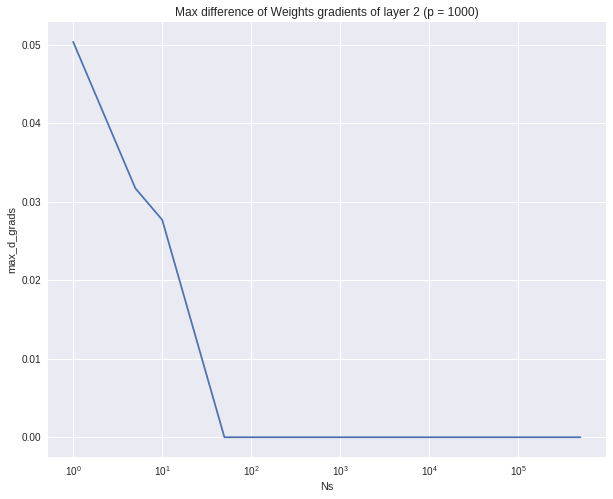

In [29]:
plt.figure(figsize = (10, 8))
plt.plot(cache["Ns"], cache["max_diffs"])
plt.xlabel('Ns')
plt.ylabel('max_d_grads')
plt.xscale('log')
#plt.yscale('log')
param_type = "Bias" if cache["use_bias"] else "Weights"
plt.title("Max difference of {} gradients of layer {} (p = {})".format(
     param_type, cache["layer_index"], cache["p"]))
#plt.show()

The max difference increases slightly when $\lg N > 4$ may be the result of the limitation of the representation accuracy from a division operation on extremely small float numbers.